In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit

In [19]:
file_path = "exp_comsol_export"  # no .txt needed if that's the actual name

# --- Step 1: Load data ---
# Skip first 9 lines 
data = pd.read_csv(file_path, sep='\s+', skiprows=9)

# Rename columns
data.columns = ['X', 'Y', 'Z', 'T_K']

In [20]:
avg_temp_per_depth = data.groupby('Z')['T_K'].mean().reset_index()

# Step 3: Sort by Z (so bottom = 0 is first)
avg_temp_per_depth = avg_temp_per_depth.sort_values(by='Z')

print("Average Temperature per Depth:")
print(avg_temp_per_depth)

z = avg_temp_per_depth['T_K']  # Temperature
t = avg_temp_per_depth['Z']    # Depth

Average Temperature per Depth:
              Z          T_K
0     -0.003750   293.000000
1     -0.003750   293.000000
2     -0.003500   293.000000
3     -0.003492   293.000000
4     -0.003421   293.000000
...         ...          ...
18104  0.153421  1492.999708
18105  0.153483  1492.999708
18106  0.153492  1492.999708
18107  0.153750  1492.999708
18108  0.153750  1492.999708

[18109 rows x 2 columns]


In [21]:
z_log = np.where(z < 0, 0, z) + 1e-6

# --- Logarithmic Fit --- (Doesn't work well)
def log_func(z, a, b):
    return a * np.log(z) + b

try:
    log_params, _ = curve_fit(log_func, z_log, t, p0=(1, np.mean(t)))
    t_log = log_func(z_log, *log_params)
    log_r2 = r2_score(t, t_log)
except RuntimeError:
    log_r2 = -np.inf

In [22]:
best_poly_r2 = -np.inf
best_poly_deg = None
best_poly_model = None

for deg in range(1, 10):
    coeffs = np.polyfit(z, t, deg=deg)
    poly_func = np.poly1d(coeffs)
    t_pred = poly_func(z)
    r2 = r2_score(t, t_pred)
    
    if r2 > best_poly_r2:
        best_poly_r2 = r2
        best_poly_deg = deg
        best_poly_model = poly_func


In [23]:
r2_scores = {
    f"Polynomial (deg={best_poly_deg})": best_poly_r2,
    "Logarithmic": log_r2
}

best_model_name = max(r2_scores, key=r2_scores.get)
best_r2 = r2_scores[best_model_name]

print("\nR² Scores for Each Model:")
for model, score in r2_scores.items():
    print(f"{model}: {score:.5f}")

print(f"\nBest Model: {best_model_name} with R² = {best_r2:.5f}")
if best_poly_model:
    print(f"\nBest Polynomial (deg={best_poly_deg}) Equation:")
    print(best_poly_model)


R² Scores for Each Model:
Polynomial (deg=9): 0.99695
Logarithmic: 0.91173

Best Model: Polynomial (deg=9) with R² = 0.99695

Best Polynomial (deg=9) Equation:
           9             8             7             6             5
6.803e-27 x - 4.428e-23 x + 1.145e-19 x - 1.408e-16 x + 5.928e-14 x
              4             3             2
 + 5.013e-11 x - 7.746e-08 x + 4.035e-05 x - 0.009168 x + 0.7432


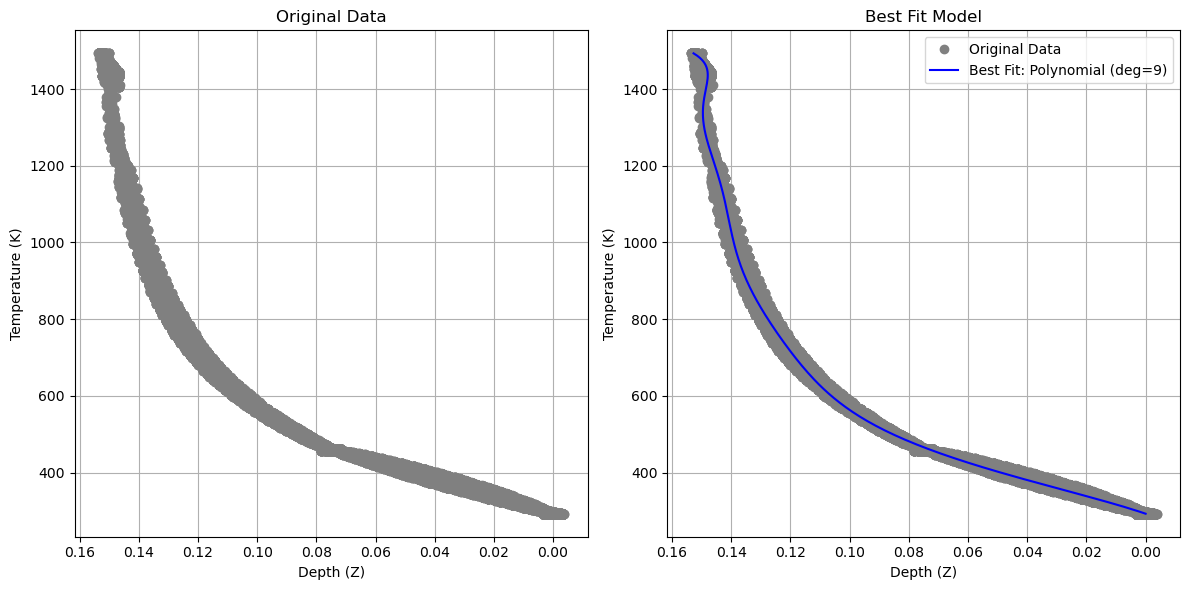

In [24]:
z_smooth = np.linspace(z.min(), z.max(), 200)

# Create side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=False, sharey=False)

# --- Plot 1: Original Data ---
axs[0].plot(t, z, 'o', color='gray')
axs[0].invert_xaxis()  # depth increases downward
axs[0].set_xlabel("Depth (Z)")  # ✅ Temp on x-axis
axs[0].set_ylabel("Temperature (K)")        # ✅ Depth on y-axis
axs[0].set_title("Original Data")
axs[0].grid(True)

# --- Plot 2: Best Fit Model ---
axs[1].plot(t, z, 'o', label='Original Data', color='gray')

if "Polynomial" in best_model_name:
    t_fit = best_poly_model(z_smooth)
else:
    z_smooth_log = np.where(z_smooth < 0, 0, z_smooth) + 1e-6
    t_fit = log_func(z_smooth_log, *log_params)

axs[1].plot(t_fit, z_smooth, '-', label=f'Best Fit: {best_model_name}', color='blue')
axs[1].invert_xaxis()  # depth increases downward
axs[1].set_xlabel("Depth (Z)")  # ✅ Temp on x-axis
axs[1].set_ylabel("Temperature (K)")        # ✅ Depth on y-axis
axs[1].set_title("Best Fit Model")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()